## Importações

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np

## Estatísticas do dataset original
**Extraído de https://www.kaggle.com/code/rounakbanik/movie-recommender-systems/data**

In [ ]:
ratings = pd.read_csv('original-ratings_small.csv')
ratings

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [ ]:
print('Quantidade de valores únicos de cada coluna:')
ratings.nunique()

Quantidade de valores únicos de cada coluna:


userId         671
movieId       9066
rating          10
timestamp    78141
dtype: int64

In [ ]:
print('Estatísticas da coluna rating:')
ratings['rating'].describe().transpose()

Estatísticas da coluna rating:


count    100004.000000
mean          3.543608
std           1.058064
min           0.500000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [ ]:
print('Quantidade de valores faltantes em cada coluna:')
ratings.isnull().sum()

Quantidade de valores faltantes em cada coluna:


userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Quantidade de cada valor único de rating:


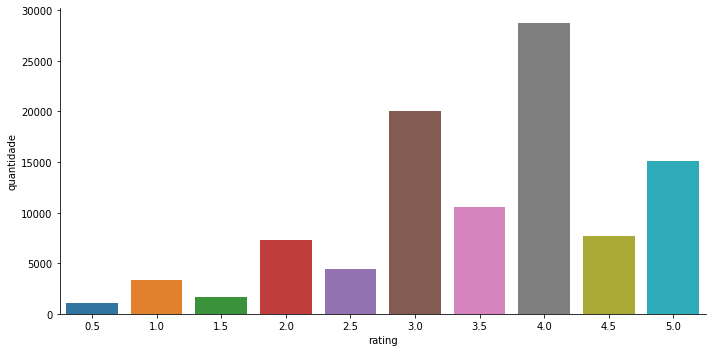

In [ ]:
print('Quantidade de cada valor único de rating:')
g = sns.catplot(x='rating', data=ratings, aspect=2.0, kind='count').set_ylabels('quantidade')

## Estatísticas do subset com os 100 usuários que mais avaliaram

In [ ]:
print('Subset com os 100 usuários que mais avaliaram:')
rated100 = ratings.groupby('userId').size().sort_values(ascending=False)[:100]
subset = ratings.loc[ratings['userId'].isin(rated100.index)]
subset

Subset com os 100 usuários que mais avaliaram:


,userId,movieId,rating,timestamp
962,15,1,2.0,997938310
963,15,2,2.0,1134521380
964,15,5,4.5,1093070098
965,15,6,4.0,1040205753
966,15,10,3.0,1093028290
...,...,...,...,...
99688,665,5502,4.0,1046967596
99689,665,5679,3.0,1046967679
99690,665,5952,5.0,1046967408
99691,665,5991,4.0,1046967253


Variabilidade de rating por usuário:


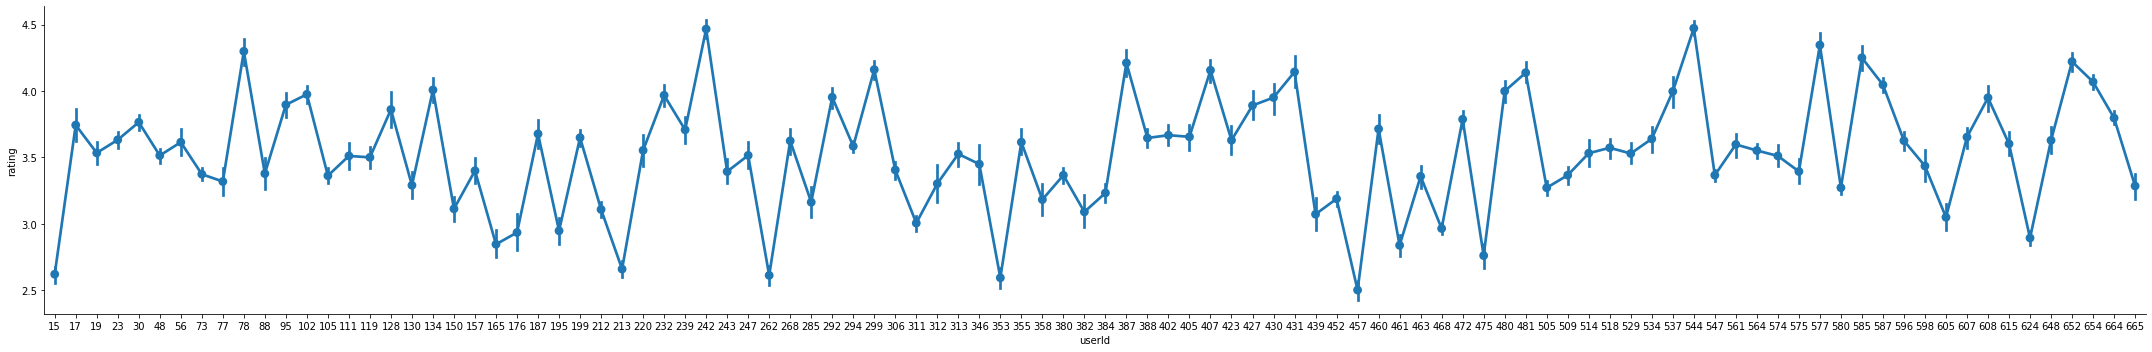

In [ ]:
print('Variabilidade de rating por usuário:')
g = sns.catplot(x='userId', y='rating', data=subset, aspect=6.0, kind='point')

Variabilidade de rating por usuário:


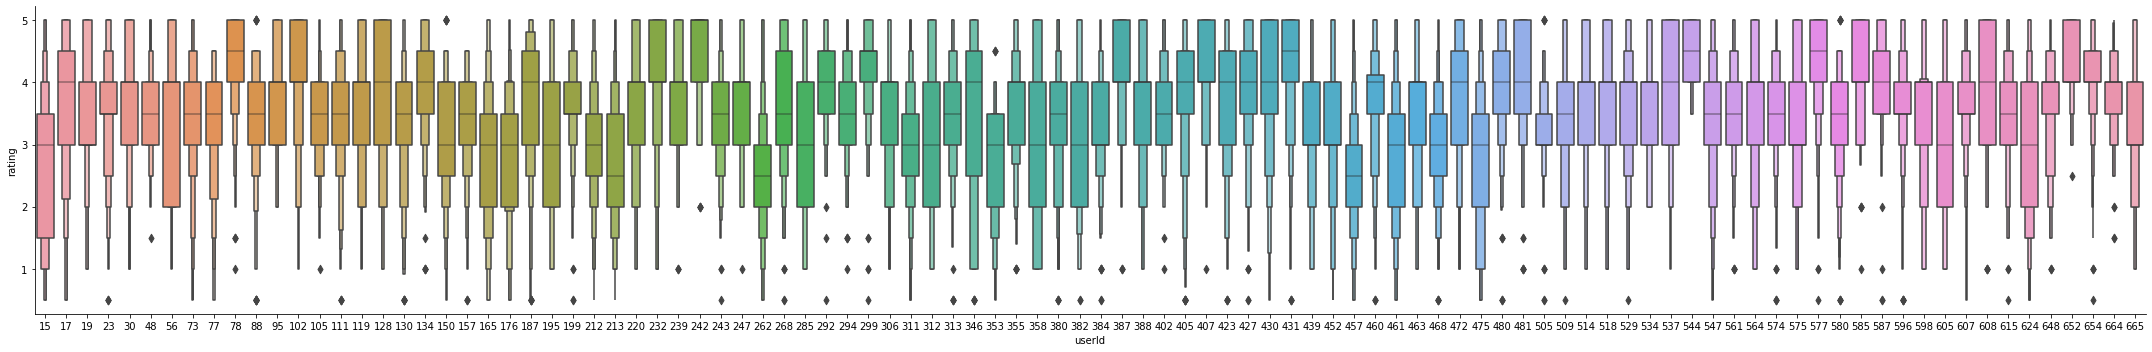

In [ ]:
print('Variabilidade de rating por usuário:')
g = sns.catplot(x='userId', y='rating', data=subset, aspect=6.0, kind='boxen')

In [ ]:
print('Quantidade de valores únicos de cada coluna:')
subset.nunique()

Quantidade de valores únicos de cada coluna:


userId         100
movieId       8291
rating          10
timestamp    43974
dtype: int64

In [ ]:
print('Estatísticas da cada coluna rating:')
subset['rating'].describe().transpose()

Estatísticas da cada coluna rating:


count    55141.000000
mean         3.421891
std          1.045267
min          0.500000
25%          3.000000
50%          3.500000
75%          4.000000
max          5.000000
Name: rating, dtype: float64

In [ ]:
subset = subset.drop(columns=['timestamp'])
subset

,userId,movieId,rating
962,15,1,2.0
963,15,2,2.0
964,15,5,4.5
965,15,6,4.0
966,15,10,3.0
...,...,...,...
99688,665,5502,4.0
99689,665,5679,3.0
99690,665,5952,5.0
99691,665,5991,4.0


## Processamento do subset

### Novos IDs para os filmes
**Construção de ratings-only.csv**

In [ ]:
novies = pd.read_csv('movies_metadata.csv')
novies

In [ ]:
subset.insert(2, 'movieTitle', subset['movieId'])

In [ ]:
# Lista de títulos sem duplicatas
import collections
titlesraw = list(novies['title'])
p = [item for item, count in collections.Counter(titlesraw).items() if count > 1]
titles = [item for item in titlesraw if item not in p]

In [ ]:
# Pareando os títulos com novos IDs, de acordo com os que existem no subset
for id in subset['movieId'].unique():
    subset = subset.replace({'movieTitle': {id: titles.pop(0)}})

In [ ]:
subset

,userId,movieId,movieTitle,rating
0,15,1,Toy Story,2.0
1,15,2,Jumanji,2.0
2,15,5,Grumpier Old Men,4.5
3,15,6,Waiting to Exhale,4.0
4,15,10,Father of the Bride Part II,3.0
...,...,...,...,...
55136,665,5502,One Flew Over the Cuckoo's Nest,4.0
55137,665,5679,Army of Darkness,3.0
55138,665,5952,Annie Hall,5.0
55139,665,5991,The Terminator,4.0


In [ ]:
print('Quantidade de valores únicos de cada coluna:')
subset.nunique()

Quantidade de valores únicos de cada coluna:


userId         100
movieId       8291
movieTitle    8291
rating          10
dtype: int64

In [ ]:
subset.to_csv('ratings-only.csv', header=True, index=False)

### Tratando o csv com os outros dados dos filmes
**Construção de movies-only.csv**



In [ ]:
novies = pd.read_csv('original-movies_metadata.csv')

In [ ]:
novies = novies.rename(columns={'id': 'original_id'})

In [ ]:
novies = novies.loc[novies['title'].isin(list(subset['movieTitle']))]
novies.insert(0, 'current_id', novies['title'])

In [ ]:
# Selecionando apenas os filmes desejados
for id in subset['movieId'].unique():
    title = subset.loc[subset['movieId'] == id].iloc[0]['movieTitle']
    novies = novies.replace({'current_id': {title: id}})

In [ ]:
novies = novies.rename(columns={'actual_id': 'currentId'})
novies = novies.rename(columns={'release_date': 'releaseDate'})
novies = novies.rename(columns={'poster_path': 'posterPath'})

In [ ]:
# Selecionando apenas as colunas desejadas
novies = novies[['currentId', 'title', 'overview', 'genres', 'runtime', 'releaseDate', 'posterPath']]

In [ ]:
# Verificando se há valores nulos
novies[novies.isna().any(axis=1)]

In [ ]:
# Os dados de um filme qualquer foram usados para substituir os valores nulos
subst = novies.loc[novies['title'] == 'Powder']

In [ ]:
for col in novies.columns[2:]:
  novies[col] = novies[col].fillna(subst.iloc[0][col])

In [ ]:
# Extraindo dos generos e corrigindo a url dos posters

import regex

for k in range(len(novies)):
  genres = regex.findall(r"('name': '\w+')", novies.iloc[k]['genres'])
  for i in range(len(genres)):
    genres[i] = genres[i][9:-1]
  genres = ', '.join(genres)
  novies.at[k, 'genres'] = genres
  novies.at[k, 'posterPath'] = 'https://flixpatrol.com/runtime/cache/files/posters/g/w350' + novies.iloc[k]['posterPath']

In [ ]:
novies

In [ ]:
novies.to_csv('movies-only.csv', header=True, index=False)

### Unindo ratings com movies
**Construção de movies-ratings**

In [ ]:
subset = pd.read_csv('ratings-only.csv')
novies = pd.read_csv('movies-only.csv')

In [ ]:
subset.insert(4, 'overview', subset['movieId'])
subset.insert(5, 'genres', subset['movieId'])
subset.insert(6, 'runtime', subset['movieId'])
subset.insert(7, 'releaseDate', subset['movieId'])
subset.insert(8, 'posterPath', subset['movieId'])
subset

,userId,movieId,movieTitle,rating,overview,genres,runtime,releaseDate,posterPath
0,15,1,Toy Story,2.0,1,1,1,1,1
1,15,2,Jumanji,2.0,2,2,2,2,2
2,15,5,Grumpier Old Men,4.5,5,5,5,5,5
3,15,6,Waiting to Exhale,4.0,6,6,6,6,6
4,15,10,Father of the Bride Part II,3.0,10,10,10,10,10
...,...,...,...,...,...,...,...,...,...
55136,665,5502,One Flew Over the Cuckoo's Nest,4.0,5502,5502,5502,5502,5502
55137,665,5679,Army of Darkness,3.0,5679,5679,5679,5679,5679
55138,665,5952,Annie Hall,5.0,5952,5952,5952,5952,5952
55139,665,5991,The Terminator,4.0,5991,5991,5991,5991,5991


In [ ]:
# Colocando os valores das novas colunas em seus IDs correspondentes
for id in subset['movieId'].unique():
  for col in novies.columns[2:]:
    iten = novies.loc[novies['currentId'] == id].iloc[0][col]
    subset = subset.replace({col: {id: iten}})

In [ ]:
# Verificando se há valores nulos
subset[subset.isna().any(axis=1)]

,userId,movieId,movieTitle,rating,overview,genres,runtime,releaseDate,posterPath


In [ ]:
subset.to_csv('movies-ratings.csv', header=True, index=False)